This notebook will try to answer a mixed bag of questions using recordings across three microphones (SMP1,7 and GRAS 1/4"), and angles. 

1. How stable is the playback of the speaker across time? [link](#q1)
    * These recordings have on-axis recordings with the GRAS mic. 
2. How much variation is there from one SMP mic to the other?
    * Comparison of sensitivity across different frequencies between SMP1 and 7. 

In [1]:
import dateutil

In [2]:
import datetime as dt
import dateutil
import glob
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import scipy.signal as signal 
import scipy.stats as stats
import soundfile as sf
from fullscale_calculations import *
from playback_code.playback_analysis import *

In [3]:
fs = 192000
dB = lambda X : 20*np.log10(abs(X))
dbrms = lambda X: dB(np.sqrt(np.mean(X**2.0)))
b,a = signal.butter(2,8000/fs*0.5,'high')
highpass = lambda X: signal.filtfilt(b,a,X)

In [4]:
print(f'Notebook cell run at : {dt.datetime.now()}')

Notebook cell run at : 2021-04-29 14:10:05.913795


In [5]:
%matplotlib notebook

<a id='q1'></a>
## How stable is the speaker playback across time?
The measurements were performed across about 1hour 15 mins. 

In [6]:
gras_files_onaxis = glob.glob('2021-04-22\\gras_gaindB_46_azimuth_angle_0_*')
gras_files_onaxis

['2021-04-22\\gras_gaindB_46_azimuth_angle_0_2021-04-22_14-57-04.wav',
 '2021-04-22\\gras_gaindB_46_azimuth_angle_0_2021-04-22_14-58-24.wav',
 '2021-04-22\\gras_gaindB_46_azimuth_angle_0_2021-04-22_14-58-54.wav',
 '2021-04-22\\gras_gaindB_46_azimuth_angle_0_2021-04-22_14-59-17.wav',
 '2021-04-22\\gras_gaindB_46_azimuth_angle_0_2021-04-22_14-59-39.wav',
 '2021-04-22\\gras_gaindB_46_azimuth_angle_0_2021-04-22_15-00-02.wav',
 '2021-04-22\\gras_gaindB_46_azimuth_angle_0_2021-04-22_16-06-49.wav',
 '2021-04-22\\gras_gaindB_46_azimuth_angle_0_2021-04-22_16-07-16.wav',
 '2021-04-22\\gras_gaindB_46_azimuth_angle_0_2021-04-22_16-14-08.wav']

<IPython.core.display.Javascript object>


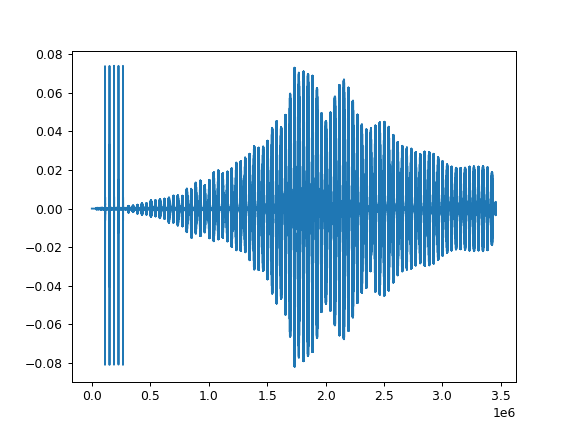

In [7]:
plt.figure()
plt.plot(sf.read(gras_files_onaxis[0])[0])

In [8]:
fs = 192000
half_durn = 9 # secs
half_durnsamples = int(half_durn*fs)
sweeps_section = int(1.5*fs)
audio_hp = []
tones_dbrms = []
audio_dbrms1half = []
audio_dbrms2half = []
sweeps_dbrms = []
silence_dbrms = []
tones_dbrms = []
for each in gras_files_onaxis:
    audio,fs = sf.read(each)
    highpassed = highpass(audio)
    audio_hp.append(highpassed)
    tones_dbrms.append(dbrms(highpassed[int(1.5*fs):]))
    audio_dbrms1half.append(dbrms(highpassed[int(1.5*fs):half_durnsamples]))
    audio_dbrms2half.append(dbrms(highpassed[half_durnsamples:]))
    sweeps_dbrms.append(dbrms(highpassed[int(0.5*fs):sweeps_section]))
    silence_dbrms.append(dbrms(highpassed[:int(0.5*fs)]))

In [9]:
datetimes_files = []
for each in gras_files_onaxis:
    timestamp = each[-23:-4]
    ymd, hhmmss = timestamp.split('_')
    fmted_ts = ymd + ' ' + hhmmss.replace('-',':')
    datetimes_files.append(dateutil.parser.parse(fmted_ts))

In [10]:
datetimes_files[0]

datetime.datetime(2021, 4, 22, 14, 57, 4)

In [11]:
time_since_start = [ (each-datetimes_files[0]).seconds/60.0 for each in datetimes_files] # minutes 

In [12]:
time_since_start[0] += 0.25 # just adding 1/4 a minute to help with visualisation -- THIS IS ACTUALLY 0 SECONDS WRT START!!

<IPython.core.display.Javascript object>


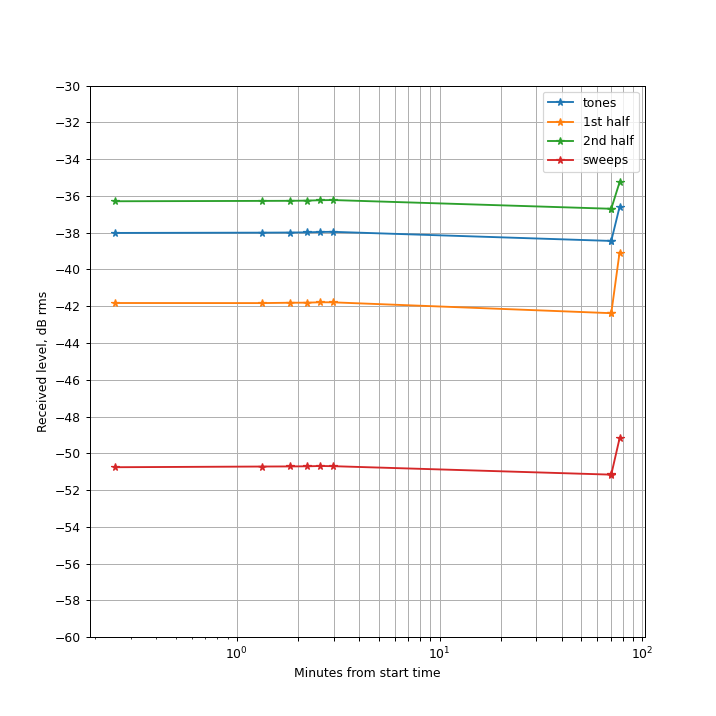

In [13]:
plt.figure(figsize=(8,8))
a0 = plt.subplot(111)
plt.plot(time_since_start, tones_dbrms,'-*',label='tones')
plt.plot(time_since_start, audio_dbrms1half,'-*',label='1st half')
plt.plot(time_since_start, audio_dbrms2half,'-*',label='2nd half')
plt.plot(time_since_start, sweeps_dbrms,'-*',label='sweeps')
#plt.xticks(range(len(wavfiles)),angles,rotation=60);
plt.legend()
plt.ylim(-60,-30);plt.yticks(np.arange(-60,-28,2));plt.grid()
plt.ylabel('Received level, dB rms');plt.xlabel('Minutes from start time');
a0.set_xscale('log');
plt.xticks(np.concatenate((np.arange(1,11), np.arange(20,110,10))));

In [14]:
diff_to_first = lambda X : X-X[0]

<IPython.core.display.Javascript object>


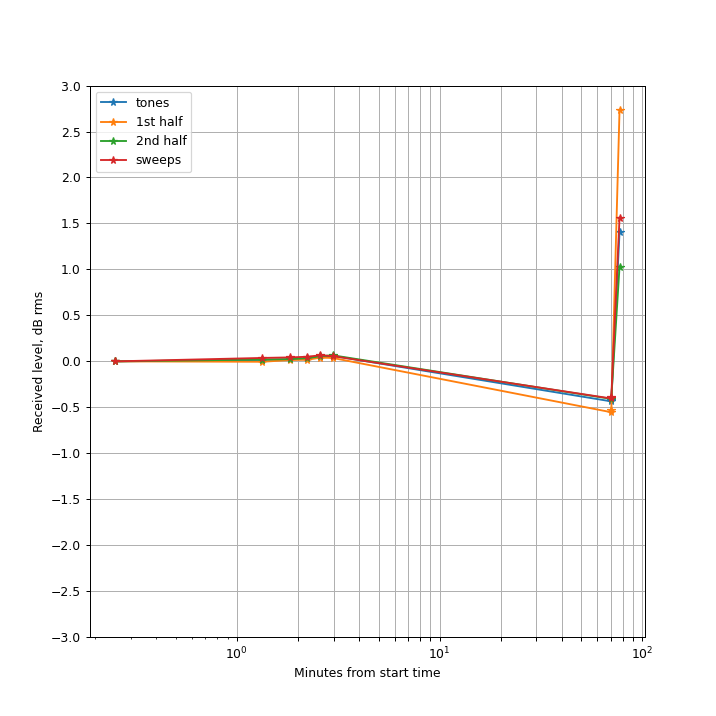

In [15]:
plt.figure(figsize=(8,8))
a0 = plt.subplot(111)
plt.plot(time_since_start, diff_to_first(tones_dbrms),'-*',label='tones')
plt.plot(time_since_start, diff_to_first(audio_dbrms1half),'-*',label='1st half')
plt.plot(time_since_start, diff_to_first(audio_dbrms2half),'-*',label='2nd half')
plt.plot(time_since_start, diff_to_first(sweeps_dbrms),'-*',label='sweeps')
#plt.xticks(range(len(wavfiles)),angles,rotation=60);
plt.legend()
plt.ylim(-3,3);plt.yticks(np.arange(-3,3.5,0.5));plt.grid()
plt.ylabel('Received level, dB rms');plt.xlabel('Minutes from start time');
a0.set_xscale('log');
plt.xticks(np.concatenate((np.arange(1,11), np.arange(20,110,10))));

### There is a weird jump of at least 1.5-2.5 dB in source level. The largest jump can be localised to the 1st half of the recording. Let's take a look using a power spectrum. 

 ### NEED TO TAKE A MORE DEEPER LOOK TO SEE WHERE THE OVERALL DIFFERENCE IS COMING FROM - THE SWEEPS OR THE TONES!!

In [16]:
first_audio, _ = sf.read(gras_files_onaxis[0], start=int(1.5*fs))
last_audio, _ = sf.read(gras_files_onaxis[-1], start=int(1.5*fs))
firstlast = [first_audio, last_audio]
power_spectra = [dB(np.fft.rfft(each)) for each in firstlast]
freqs = np.fft.rfftfreq(firstlast[0].size, 1/fs)

In [17]:
# threshold out the noise to see the difference better
threshold = 3
def threshold_spectra(X, threshold, thresh_val=0):
    leq_threshold = X<=threshold
    thresh_X = X.copy()
    thresh_X[leq_threshold] = thresh_val
    return thresh_X
power_spectra_cleaned = [ threshold_spectra(each, 5) for each in power_spectra]

<IPython.core.display.Javascript object>


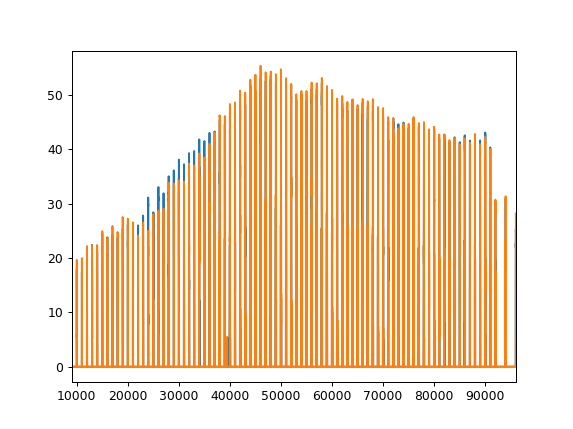

(9000.0, 96000.0)

In [18]:
plt.figure()
plt.plot(freqs,power_spectra_cleaned[0])
plt.plot(freqs,power_spectra_cleaned[1])
plt.xlim(9000, fs*0.5)

In [19]:
smooth_powerspectra = [np.convolve(each,np.ones(20)/20,'same') for each in power_spectra_cleaned]
diffspectra = power_spectra_cleaned[1]-power_spectra_cleaned[0]


In [20]:
smooth_diffspectra = signal.medfilt(diffspectra, 251)

<IPython.core.display.Javascript object>


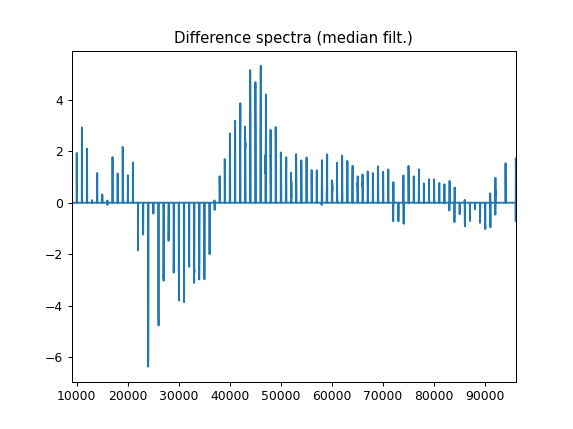

In [21]:
plt.figure()
plt.plot(freqs,smooth_diffspectra)
plt.xlim(9000, fs*0.5);plt.title('Difference spectra (median filt.)');

### There may be some kind of frequency dependent up and down shift across time. 

This observation begs the question:
* Would changing the speaker have an effect?
* Would reducing the playback/experiment duration have an effect?

### Speaker playback levels across frequency

We know the GRAS 1/4" mic has a sensitivity of -49.7 Vrms/Pa ($\pm$0.72 dB between 250Hz-100kHz), and the Fireface 802 front instrument port has a full-scale of 27dBu. The mic was ona 46 dB gain. 

Let's calculate the received level of each frequency. 

In [22]:
# load the original playback sequence :
import playback_code.microphone_calib_playbacks as mcp

In [23]:
playback_sounds, numsamples_comlength = mcp.make_playback_sounds()
playback_sounds = np.concatenate(playback_sounds).flatten()

In [24]:
def process_audio_and_split(audio):

    audio = audio[int(0.4*fs):] # exclude the empty read buffer

    first200ms = int(0.2*fs)
    first700ms = int(0.7*fs)
    corr = signal.correlate(playback_sounds[:first200ms], audio[:first200ms], 'full')
    delay = np.round(corr.size/2) - np.argmax(corr)

    audio_tc = audio[int(delay):] # time corrected
    #audio_tc = audio_tc[int(0.2*fs):] # exclude the first empty read
    audio_bp = signal.filtfilt(b,a,audio_tc)
    extra_after = np.remainder(audio_bp.size/fs, 0.2) # remove the end tones that are incomplete
    audio_bp = audio_bp[:-int(extra_after*fs)]
    rec_parts = np.array_split(audio_bp, int(audio_bp.size/38400)) 
    
    # bandpass filter all portions from 10-91kHz
    rec_bp_parts = []
    tone_freqs = np.arange(10,92,1)*10**3
    for index, pkfreq in zip(range(5,len(rec_parts)), tone_freqs):
        b_bp, a_bp = signal.butter(2, np.array([pkfreq-500, pkfreq+500])/(fs*0.5), 'bandpass')
        rec_bp_parts.append(signal.lfilter(b_bp, a_bp, rec_parts[index])) 
    return rec_parts, rec_bp_parts

In [25]:
def calculate_peak_eq_source_level_dbspl(audio_segments, gain, sensitivity_dbvrmspa, FS_dbu):
    waveform_pp = [ wave_p2p(each) for each in audio_segments]
    waveform_dbpp = dB( np.array(waveform_pp)/2.0) # re 2
    waveform_dbpp += -gain # remove gain to get actual pp
    # FS of Fireface 802 in dB Vpp re 1V
    fs_vpp = dbu2vp2p(FS_dbu)
    fs_dbV = dB(fs_vpp)
    playback_levels_dbV = fs_dbV + waveform_dbpp# #  dBVpp re 1
    sensitivity_vrms = 10**(sensitivity_dbvrmspa/20.0) # Vrms/Pa
    sensitivity_vpp = vrms2vp2p(sensitivity_vrms) # Vpp/Pa
    playback_levels_V = 10**(playback_levels_dbV/20.0) # V
    playback_levels_pa = playback_levels_V*(1/sensitivity_vpp) # Pa
    
    ref_level = 20*10**-6
    playback_levels_spl = dB(playback_levels_pa/ref_level) # SPL (Pa re 20muPa)
    return playback_levels_spl

In [26]:
tone_freqs = np.arange(10,92)

In [27]:
filespecific_tonesspl = {}
filesp_sweepspl = {}
for i, each in enumerate(gras_files_onaxis):
    audio, fs = sf.read(each)
    all_parts, bp_tones = process_audio_and_split(audio)
    tones_spl =  calculate_peak_eq_source_level_dbspl(bp_tones, 46, -49.7, 27)
    
    sweeps_splt = calculate_peak_eq_source_level_dbspl(all_parts[:5], 46, -49.7, 27)
    
    filespecific_tonesspl[i] = tones_spl
    filesp_sweepspl[i] = sweeps_splt

In [28]:
sweep_spl = [value for key, value in filesp_sweepspl.items()]

<IPython.core.display.Javascript object>


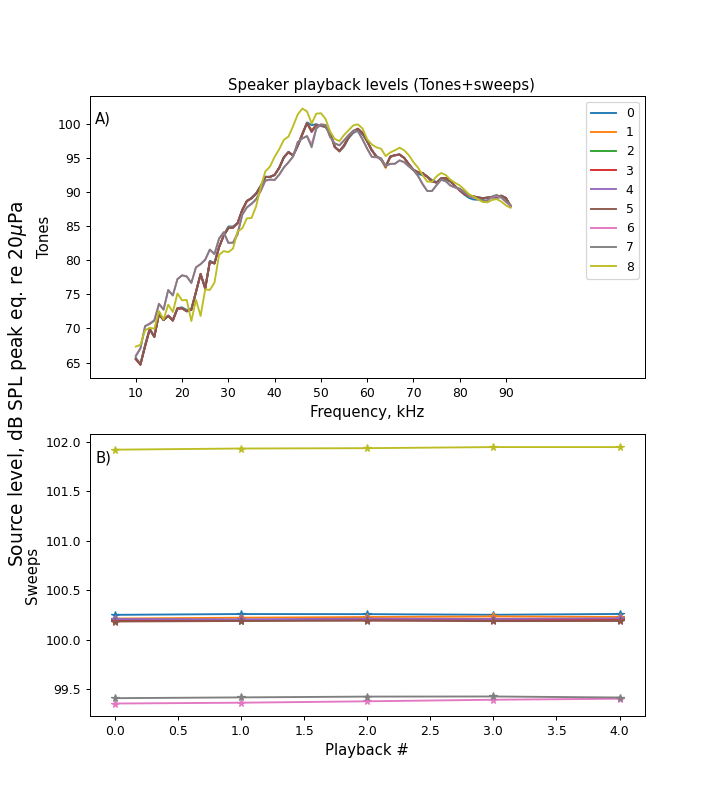

Text(0, 0.5, 'Sweeps')

In [29]:

plt.figure(figsize=(8,9))
a0 = plt.subplot(111)
plt.subplot(211)
for key, value in filespecific_tonesspl.items():
    plt.plot(tone_freqs, value, label=str(key));
plt.legend();plt.xlim(0,120);plt.xticks(np.arange(10,91,10));plt.xlabel('Frequency, kHz', fontsize=12)
plt.ylabel('Tones', fontsize=12)
plt.text(0.01,0.90,'A)', fontsize=12, transform=plt.gca().transAxes)

plt.subplot(212)
for each in sweep_spl:
    plt.plot(each, '-*')
plt.text(-0.15,0.25,'Source level, dB SPL peak eq. re 20$\mu$Pa', fontsize=15, rotation=90,transform=a0.transAxes)
plt.text(0.25,1.01,'Speaker playback levels (Tones+sweeps)', fontsize=12, transform=a0.transAxes)
plt.text(0.01,0.90,'B)', fontsize=12, transform=plt.gca().transAxes)
plt.xlabel('Playback #', fontsize=12);plt.ylabel('Sweeps', fontsize=12)

Playback levels for tones (A) and sweeps (B). The variation in tone levels is higher for lower frequencies than for higher frequencies.

### Summary:
* The speaker shows a variation of ~$\geq$2dB across time. The level variation for pure tones (subplot A) is more than sweeps (subplot B).
* Within a playback, the level is constant for sweeps

In [30]:
file_timestamps = [each.strftime('%Y-%m-%d_%H:%M:%S') for each in datetimes_files]

In [31]:
# save the source level data to calibrate the SMPs
freqs = []
tones_spl = []
filetimes = []
for key, value in filespecific_tonesspl.items():
    freqs.append(tone_freqs)
    tones_spl.append(value)
    filetimes.append(np.tile(file_timestamps[key], tone_freqs.size))
    
tones_spl_data = pd.DataFrame(data={'tones_dbspl':np.concatenate(tones_spl).flatten(),
                                    'freq_khz': np.concatenate(freqs).flatten()})
tones_spl_data['recording_time'] = np.concatenate(filetimes)
tones_spl_data['rec_num'] = np.concatenate([np.tile(each, tone_freqs.size) for each in range(9)])
tones_spl_data.to_csv('2021-04-22_tones_spl_data.csv')

In [32]:
sweeps_spl_data = pd.DataFrame(data={})
sweeps_spl = []
sweeps_recnum = []
filetimes = []
for i, each in enumerate(sweep_spl):
    sweeps_spl.append(each)
    sweeps_recnum.append(np.tile(i, each.size))
    filetimes.append(np.tile(file_timestamps[i], each.size))
sweeps_spl_data['sweeps_dbspl'] = np.concatenate(sweeps_spl)
sweeps_spl_data['rec_num'] = np.concatenate(sweeps_recnum)
sweeps_spl_data['recording_time'] = np.concatenate(filetimes)
sweeps_spl_data.to_csv('2022-04-22_sweeps_spl_data.csv')

## The effect of microphone angle

These results need to be taken with a pinch of salt as the +2dB jump could influence the directionality measurements too!!

In [33]:
gras_files_all = glob.glob('2021-04-22\\gras_gaindB_46_azimuth_angle_*')
gras_files_offaxis = np.sort(list(set(gras_files_all) - set(gras_files_onaxis)))
gras_files_offaxis

array(['2021-04-22\\gras_gaindB_46_azimuth_angle_15_2021-04-22_16-08-22.wav',
       '2021-04-22\\gras_gaindB_46_azimuth_angle_30_2021-04-22_16-08-57.wav',
       '2021-04-22\\gras_gaindB_46_azimuth_angle_45_2021-04-22_16-09-33.wav',
       '2021-04-22\\gras_gaindB_46_azimuth_angle_60_2021-04-22_16-10-20.wav',
       '2021-04-22\\gras_gaindB_46_azimuth_angle_75_2021-04-22_16-12-43.wav',
       '2021-04-22\\gras_gaindB_46_azimuth_angle_90_2021-04-22_16-13-16.wav'],
      dtype='<U66')

In [34]:
def extract_angle(X):
    folder, file = os.path.split(X)
    
    parts = file.split('_')
    return parts[5]

In [35]:
file_angles = [extract_angle(each) for each in gras_files_offaxis]

In [36]:
filespecific_tonesspl_theta = {}
filesp_sweepspl_theta = {}
for i, each in zip(file_angles, gras_files_offaxis):
    audio, fs = sf.read(each)
    all_parts, bp_tones = process_audio_and_split(audio)
    tones_spl =  calculate_peak_eq_source_level_dbspl(bp_tones, 46, -49.7, 27)
    
    sweeps_splt = calculate_peak_eq_source_level_dbspl(all_parts[:5], 46, -49.7, 27)
    
    filespecific_tonesspl_theta[i] = tones_spl
    filesp_sweepspl_theta[i] = sweeps_splt

In [37]:
# get the mean pbk-level at each angle: 
mean_spl = [ dB(np.mean(10**(values/20))) for key, values in filesp_sweepspl_theta.items()]
mean_spl

[101.38063480445348,
 99.15879043574935,
 95.72238061053076,
 92.62426468230748,
 91.77291787272787,
 88.09101597739719]

### Angular dependence of Sweeps:

In [38]:
theta_deg = [15,30,45,60,75,90]
theta = np.radians(theta_deg)

<IPython.core.display.Javascript object>


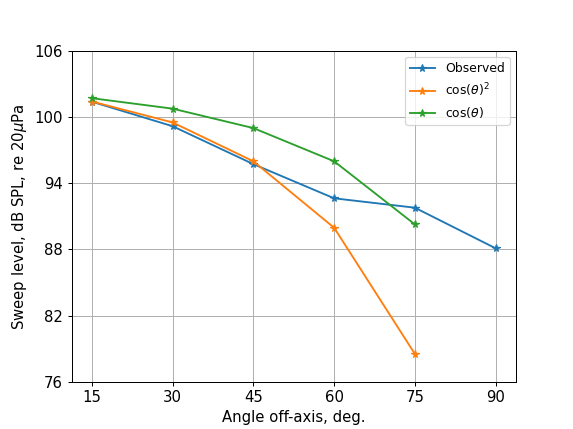

Text(0.5, 0, 'Angle off-axis, deg.')

In [39]:
plt.figure()
plt.plot(theta, mean_spl, '-*', label='Observed')
plt.plot(theta[:-1], dB(10**(102/20.0)*np.cos(theta[:-1])**2), '-*', label='cos($\\theta)^{2}$')
plt.plot(theta[:-1], dB(10**(102/20.0)*np.cos(theta[:-1])), '-*',label='cos($\\theta)$')
plt.legend();plt.yticks(fontsize=12);plt.grid();plt.yticks(np.arange(76,112,6))
plt.xticks(theta, theta_deg, fontsize=12);plt.ylabel('Sweep level, dB SPL, re 20$\mu$Pa',fontsize=12);
plt.xlabel('Angle off-axis, deg.', fontsize=12)

### Angular dependence of tones:

<IPython.core.display.Javascript object>


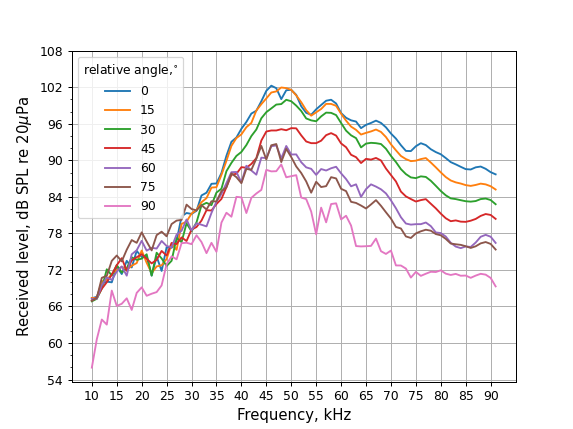

In [40]:
plt.figure()
plt.plot(filespecific_tonesspl[8], label='0')
for angle, levels  in filespecific_tonesspl_theta.items():
    plt.plot(levels, label=angle)
    
indices = np.arange(0,82,5)
plt.xticks(np.arange(82)[indices], tone_freqs[indices]);
plt.grid()
plt.legend(title='relative angle,$^{\circ}$');plt.xlabel('Frequency, kHz', fontsize=12);
plt.ylabel('Received level, dB SPL re 20$\mu$Pa', fontsize=12);
a0 = plt.gca()
a0.set_yticks(np.arange(54,112,6))
a0.set_yticks(np.arange(54,102,2),minor=True);

## How well does this match what we know from the technical specs?
The directionality of the mic at various frequencies has been characterised - as given in the datasheets [here](https://www.grasacoustics.com/products/product/143-46be.html)

In [41]:
gras_dirn = pd.read_csv('gras46bf_fromdatasheet.csv') # data digitised using WebPlotDigitizer

In [42]:
get_dbrange = lambda X : (np.max(X['rel_dB_onaxis'])-X['rel_dB_onaxis'])*-1
with_ranges = []
for freq, df in gras_dirn.groupby('freq_hz'):
    df['dbrange'] = get_dbrange(df)
    with_ranges.append(df)
    
gras_dirnlty = pd.concat(with_ranges)

And now let's re-format our own measurements in the lab to see if they match up. 

In [43]:
subset_freqs = np.arange(20000,100000,10000)
freq_inds = np.flatnonzero(np.isin(tone_freqs*1000,subset_freqs))
# now reformat the observed data to see if it matches
angles = ['30','60', '90']
only_some_angles = {}
for each in angles:
    only_some_angles[each] = filespecific_tonesspl_theta[each][[freq_inds]]
only_some_angles['0'] = filespecific_tonesspl[8][[freq_inds]]

gras_measured_dirn = []

for angle, freq_levels in only_some_angles.items():
    df = pd.DataFrame(data ={'freq_hz': subset_freqs,
                             'levels': freq_levels,
                              'angle_deg':np.tile(angle, subset_freqs.shape)})
    gras_measured_dirn.append(df)
gras_measured_dirn = pd.concat(gras_measured_dirn)

measured_with_ranges = []
for freq, df in gras_measured_dirn.groupby('freq_hz'):
    df['dbrange'] = -1*(np.max(df['levels']) - df['levels'])
    measured_with_ranges.append(df)
    
gras_measured_dirnlty = pd.concat(measured_with_ranges)


<ipython-input-43-02de7ea4e266>:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  only_some_angles[each] = filespecific_tonesspl_theta[each][[freq_inds]]
<ipython-input-43-02de7ea4e266>:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  only_some_angles['0'] = filespecific_tonesspl[8][[freq_inds]]


In [44]:
gras_measured_dirnlty.head()

,freq_hz,levels,angle_deg,dbrange
0,20000,73.849364,30,-2.927217
0,20000,76.776581,60,-0.000000
0,20000,69.140801,90,-7.635780
0,20000,74.122661,0,-2.653919
1,30000,78.339964,30,-2.853025


<IPython.core.display.Javascript object>


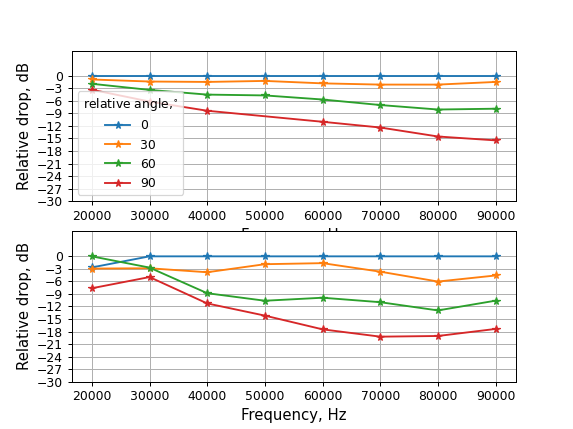

In [45]:
plt.figure()
a1 = plt.subplot(211)
for angle, df in gras_dirnlty.groupby('angle_deg'):
    plt.plot(df['freq_hz'],df['dbrange'],'-*', label=angle)
plt.ylabel('Relative drop, dB', fontsize=12); plt.xlabel('Frequency, Hz', fontsize=12)
plt.legend(title='relative angle,$^{\circ}$');plt.grid();plt.ylim(-30,6)
a1.set_yticks(np.arange(-30,3,3))

a2 = plt.subplot(212)
for angle, df in gras_measured_dirnlty.groupby('angle_deg'):
    plt.plot(df['freq_hz'],df['dbrange'],'-*', label=angle)
plt.ylabel('Relative drop, dB', fontsize=12); plt.xlabel('Frequency, Hz', fontsize=12)
#plt.legend(title='relative angle,$^{\circ}$')
plt.grid();plt.ylim(-30,6)
a2.set_yticks(np.arange(-30,3,3));



<IPython.core.display.Javascript object>


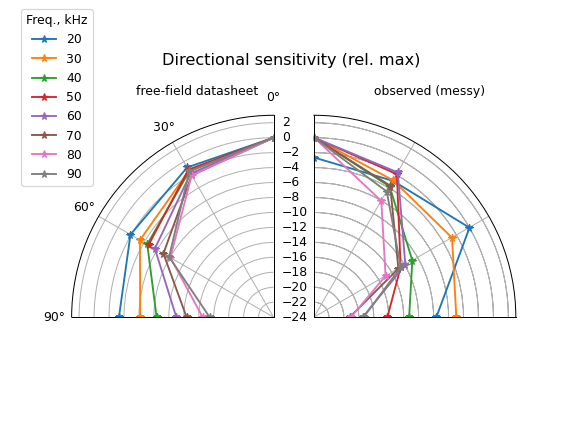

In [108]:
plt.figure()
a1 = plt.subplot(121, projection='polar')
a1.set_theta_zero_location("N")
for freq, df in gras_dirnlty.groupby('freq_hz'):
    plt.plot(np.radians(df['angle_deg']),df['dbrange'],'-*',
                        label=str(int(freq/1000)))
plt.text(0.32, 1.1, 'free-field datasheet', transform=a1.transAxes)
a1.set_thetamax(90);
#plt.legend(loc='lower right')
plt.legend(loc=(-0.25,0.65), title='Freq., kHz')
plt.ylim(-24,3);plt.xlim()

a2 = plt.subplot(122, projection='polar')
a2.set_theta_zero_location("N")

for freq, df in gras_measured_dirnlty.groupby('freq_hz'):
    df = df.sort_values('angle_deg')
    plt.plot(2*np.pi-np.radians(np.float16(df['angle_deg'])),df['dbrange'],'-*',
             label=str(int(freq/1000)))
a2.set_thetamax(-90)
plt.text(0.3, 1.1, 'observed (messy)', transform=a2.transAxes)
plt.text(-0.75, 1.25, 'Directional sensitivity (rel. max)', transform=a2.transAxes, fontsize=13)

plt.ylim(-24,3);
#plt.legend()
yticks = np.arange(-24,3,2);
a1.set_yticks(yticks);
a1.set_xticks(np.radians(np.arange(0,120,30)));
plt.xticks(2*np.pi-np.radians(np.arange(0,120,30)), []);
plt.yticks(yticks,[]);
#a1.set_yticks(np.arange(-30,3,3),minor=True)
#a1.set_xticks(np.radians([0,30,60,90]))
#a1.set_xticks(-np.radians([0,30,60,90]))

### Does the free-filed observed data at least match the tech specs.?
On 29/4 I also did extra measurements with the GRAS mic (without cap) only - in the absence of the 'wall' - at 0,30,60, and 90 degrees. Do the measurements here match at least? 

In [68]:
freefield_gras_files = glob.glob('2021-04-29/*.wav')
freefield_gras_onaxis = glob.glob('2021-04-29/gras_gaindB_46_azimuth_angle_0_*')
freefield_gras_theta = list(set(freefield_gras_files)-set(freefield_gras_onaxis))
freefield_gras_theta.append(freefield_gras_onaxis[0])
ff_gras_theta = np.sort(freefield_gras_theta)


In [72]:
freefield_tonesspl_theta = {}
freefield_sweepspl_theta = {}
for i, each in zip(['0', '30', '60','90'], ff_gras_theta):
    audio, fs = sf.read(each)
    all_parts, bp_tones = process_audio_and_split(audio)
    tones_spl =  calculate_peak_eq_source_level_dbspl(bp_tones, 46, -49.7, 27)
    
    sweeps_splt = calculate_peak_eq_source_level_dbspl(all_parts[:5], 46, -49.7, 27)
    
    freefield_tonesspl_theta[i] = tones_spl
    freefield_sweepspl_theta[i] = sweeps_splt

In [73]:
angles = ['0','30','60', '90']
only_some_angles = {}
for each in angles:
    only_some_angles[each] = freefield_tonesspl_theta[each][[freq_inds]]

ff_gras_measured_dirn = []

for angle, freq_levels in only_some_angles.items():
    df = pd.DataFrame(data ={'freq_hz': subset_freqs,
                             'levels': freq_levels,
                              'angle_deg':np.tile(angle, subset_freqs.shape)})
    ff_gras_measured_dirn.append(df)
ff_gras_measured_dirn = pd.concat(ff_gras_measured_dirn)

measured_with_ranges = []
for freq, df in ff_gras_measured_dirn.groupby('freq_hz'):
    df['dbrange'] = -1*(np.max(df['levels']) - df['levels'])
    measured_with_ranges.append(df)

ff_gras_measured_dirn = pd.concat(measured_with_ranges)


<ipython-input-73-61ffa3e04253>:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  only_some_angles[each] = freefield_tonesspl_theta[each][[freq_inds]]


<IPython.core.display.Javascript object>


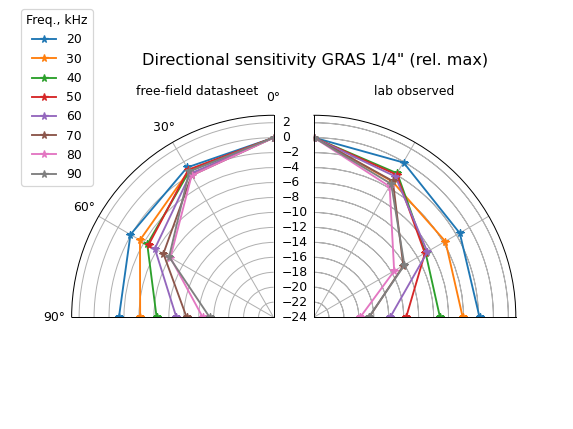

In [109]:
plt.figure()
a1 = plt.subplot(121, projection='polar')
a1.set_theta_zero_location("N")
for freq, df in gras_dirnlty.groupby('freq_hz'):
    plt.plot(np.radians(df['angle_deg']),df['dbrange'],'-*',
                        label=str(int(freq/1000)))
plt.text(0.32, 1.1, 'free-field datasheet', transform=a1.transAxes)
a1.set_thetamax(90);
#plt.legend(loc='lower right')
plt.legend(loc=(-0.25,0.65), title='Freq., kHz')
plt.ylim(-24,3);plt.xlim()
a2 = plt.subplot(122, projection='polar')
a2.set_theta_zero_location("N")

for freq, df in ff_gras_measured_dirn.groupby('freq_hz'):
    df = df.sort_values('angle_deg')
    plt.plot(2*np.pi-np.radians(np.float16(df['angle_deg'])),df['dbrange'],'-*',
             label=str(int(freq/1000)))
a2.set_thetamax(-90)
plt.text(0.3, 1.1, 'lab observed', transform=a2.transAxes)
plt.text(-0.85, 1.25, 'Directional sensitivity GRAS 1/4" (rel. max)', transform=a2.transAxes, fontsize=13)

plt.ylim(-24,3);
#plt.legend()
yticks = np.arange(-24,3,2);
a1.set_yticks(yticks);
a1.set_xticks(np.radians(np.arange(0,120,30)));
plt.xticks(2*np.pi-np.radians(np.arange(0,120,30)), []);
plt.yticks(yticks,[]);
#a1.set_yticks(np.arange(-30,3,3),minor=True)
#a1.set_xticks(np.radians([0,30,60,90]))
#a1.set_xticks(-np.radians([0,30,60,90]))

In [81]:
ff_gras_measured_dirn[ff_gras_measured_dirn['freq_hz']==50000]

,freq_hz,levels,angle_deg,dbrange
3,50000,99.743515,0,-0.000000
3,50000,97.774604,30,-1.968911
3,50000,92.867600,60,-6.875915
3,50000,88.076020,90,-11.667496


The match to the technical specs is much better here - though the deviation is around 2-3 dB for some frequencies at some angles - with the match being better for lower frequencies (<50kHz) than for higher. At higher frequencies there seems to be 2-3dB mismatch between the specs and the observations for a few angles (eg. 60deg), and rather good match for others. 

Ultimately, the point is that the match here is much better than the match before -- which says that there may be an effect of the board -- or of the speaker variation itself. At this point it is a bit hard to say!! 

For the free-field recordings I can be very sure the speaker level was stable -- the experiment was run over a short period of time, and the level was *very* stable for 3 test playbacks on-axis (~<0.3 dB rms variation).]

#### Summary: the methods do indeed reflect the underlying 

### How different is the directionality with and without the wall?

In [92]:
gras_measured_dirnlty['angle_deg'][0]

0    30
0    60
0    90
0     0
Name: angle_deg, dtype: object

<IPython.core.display.Javascript object>


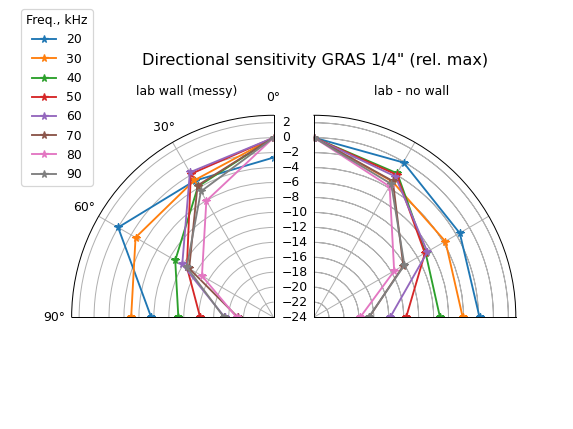

In [107]:
plt.figure()
a1 = plt.subplot(121, projection='polar')
a1.set_theta_zero_location("N")
for freq, df in gras_measured_dirnlty.groupby('freq_hz'):
    df ['angle_deg'] = df['angle_deg'].astype('float')
    df = df.sort_values('angle_deg')
    plt.plot(np.radians(df ['angle_deg']),
                         df['dbrange'],'-*',
                        label=str(int(freq/1000)))
plt.text(0.32, 1.1, 'lab wall (messy)', transform=a1.transAxes)
a1.set_thetamax(90);
#plt.legend(loc='lower right')
plt.legend(loc=(-0.25,0.65), title='Freq., kHz')
plt.ylim(-24,3);plt.xlim()


# -- l
a2 = plt.subplot(122, projection='polar')
a2.set_theta_zero_location("N")

for freq, df in ff_gras_measured_dirn.groupby('freq_hz'):
    df = df.sort_values('angle_deg')
    plt.plot(2*np.pi-np.radians(np.float16(df['angle_deg'])),df['dbrange'],'-*',
             label=str(int(freq/1000)))
a2.set_thetamax(-90)
plt.text(0.3, 1.1, 'lab - no wall', transform=a2.transAxes)
plt.text(-0.85, 1.25, 'Directional sensitivity GRAS 1/4" (rel. max)', transform=a2.transAxes, fontsize=13)

plt.ylim(-24,3);
#plt.legend()
yticks = np.arange(-24,3,2);
a1.set_yticks(yticks);
a1.set_xticks(np.radians(np.arange(0,120,30)));
plt.xticks(2*np.pi-np.radians(np.arange(0,120,30)), []);
plt.yticks(yticks,[]);
#a1.set_yticks(np.arange(-30,3,3),minor=True)
#a1.set_xticks(np.radians([0,30,60,90]))

The broad patterns seem to match actually. The issue here is to exclude the inter-playback speaker source level variation!! How to take care of this is the next question. Perhaps I need to run a round with and without the wall to see if there is actually an effect. 

In [87]:
4/192000

2.0833333333333333e-05

In [98]:
print(f'Notebook cell run at : {dt.datetime.now()}')

Notebook cell run at : 2021-04-28 17:30:33.223357
